# Design of RC Sections for Bending

## Materials

### Concrete

The properties of concrete as per IS456:2000 are as follows:
1. Characteristic strength $f_{ck}$
2. Partial safety factor for material $\gamma_{mc} = 1.5$
3. Short term modulus of elasticity $E_c = 5000 \sqrt{f_{ck}} \text{ N/mm}^2$
4. Yield strain $\epsilon_{cy} = 0.002$
5. Ultimate strain $\epsilon_{cu} = 0.0035$

Density is usually taken to be $25 \text{ kN/m}^3$. The strain-stress relation is taken to be parabolic from $\epsilon_c = 0$ to $\epsilon_c = \epsilon_{cu}$.

The stress-strain relation can be experssed as:
\begin{align}
    f_c &= \begin{cases}
    \frac{0.67 f_{ck}}{\gamma_{mc}} \left[ 2 \left( \frac{\epsilon_c}{\epsilon_{cy}} \right) - \left( \frac{\epsilon_c}{\epsilon_{cy}} \right)^2 \right] & \text{if } 0 \leq \epsilon_c \leq \epsilon_{cy} \\
    \frac{0.67 f_{ck}}{\gamma_{mc}} & \text{if } \epsilon_{cy} < \epsilon_c \leq \epsilon_{cu} \\
    0 & \text{if } \epsilon_c < 0 \text{ or } \epsilon_c > \epsilon_{cu}
    \end{cases}
\end{align}
where $f_c$ is the compressive stress in concrete corresponding to a compressive strain $\epsilon_c$.

### Rebars
The properties of steel rebars are:
1. Characteristic strength $f_y$
2. Partial safety factor for material $\gamma_{ms} = 1.15$
3. Modulus of elasticity $E_s = 2 \times 10^5 \text{ N/mm}^2$

The strain-stress relation is linear up to yield strain and remains constant after that. It is assumed that steel rebars are inifinitely ductile, implying that the ultimate strain is inifinitely largeor at least so large that concrete would have completely failed before the bultimate strain of steel rebars is reached.

IS:456:2000 considers two types of steel rebars:
1. Rebars with a definite yield point. This is usually mild steel and has a characteristic strength $f_y = 250 \text{ N/mm}^2$.
2. Cold worked deformed steel rebars also called Highy yield strength deformed steel rebars (HYSD). They have a piece-wise linear strain-stress relationship defined in terms of plastic strain for diffeent levels of stress.

The yield strain of mild steel is well defined and is $\epsilon_{sy} = \frac{f_y}{\gamma_{ms} E_s}$. The stress-strain relation for mild steel is:
\begin{align}
    f_s &= \begin{cases}
        \frac{f_y}{\gamma_{ms}} \frac{\epsilon_s}{\epsilon_{sy}} = \epsilon_s \, E_s & \text{if } | \epsilon_s | \leq \frac{f_y}{\gamma_{ms} E_s} \\
        \frac{f_y}{\gamma_{ms}} & \text{if } \frac{f_y}{\gamma_{ms} E_s} < | \epsilon_s| < \infty
    \end{cases}
\end{align}


The stress-strain relatin for HYSD rebars is linear from $0$ up to $0.8 \frac{f_y}{\gamma_{ms}}$ and is linear beyond that stress in a piece-wise manner up to $\frac{f_y}{\gamma_{ms}}$. Beyond that, it is constant. IS456:2000 defines the plastic strain at different levels of stress between $0.8 \frac{f_y}{\gamma_{ms}}$ and $\frac{f_y}{\gamma_{ms}}$ from which stress can be calculated by interpolation between the given values of strain.

| Stress $f_s$                     | Plastic Strain $\epsilon_{sp}$ |
|:--------------------------------:|-------------------------------:|
| $0.8 \frac{f_y}{\gamma_{ms}}$    | $0$                            |
| $0.85 \frac{f_y}{\gamma_{ms}}$   | $0.0001$                       |
| $0.9  \frac{f_y}{\gamma_{ms}}$   | $0.0003$                       |
| $0.95 \frac{f_y}{\gamma_{ms}}$   | $0.0007$                       |
| $0.975 \frac{f_y}{\gamma_{ms}}$  | $0.001$                        |
| $\frac{f_y}{\gamma_{ms}}$        | $0.0002$                       |

The following code implements these calculations.

## Import the required modules and packages and define types

We begin by importing the required modules and packages. The first group are built-in modules and do not need to be explicitly installed as they come built-in with Python. The second group, namely, *numpy* aand *matplotlib* packages will have to be installed before they can be used. This will require the user to know how to install and manage packages.

In [1]:
from fractions import Fraction as F
import math
from enum import Enum
from typing import ClassVar
from typing_extensions import Annotated
from dataclasses import dataclass
from abc import ABC, abstractmethod

import numpy as np
import matplotlib.pyplot as plt
from numpy.typing import NDArray

Array2D = Annotated[NDArray[np.float64], ("n", "m")]

## Brent's method for numerical solution of equations

In [2]:
def find_bracket(f, x_start, x_end, n, **kwargs):
    """
    Find x1, x2 that bracket a root of f(x) in [x_start, x_end] by dividing
    the interval into n equal parts and scanning for a sign change.

    Parameters
    ----------
    f : callable
        Function f(x, **kwargs) whose root is sought.
    x_start, x_end : float
        Interval endpoints with x_start < x_end.
    n : int
        Number of equal divisions of the interval.
    **kwargs :
        Additional keyword arguments passed to f.

    Returns
    -------
    (x1, x2) : tuple of floats
        A pair such that f(x1) and f(x2) have opposite signs.
        Returns (None, None) if no such pair is found.
    """

    if n <= 0:
        raise ValueError("n must be a positive integer")

    dx = (x_end - x_start) / n

    x_prev = x_start
    f_prev = f(x_prev, **kwargs)

    if f_prev == 0:
        return x_prev, x_prev

    for i in range(1, n + 1):
        x_curr = x_start + i * dx
        f_curr = f(x_curr, **kwargs)

        if f_prev * f_curr < 0:
            return x_prev, x_curr

        if f_curr == 0:
            return x_curr, x_curr

        x_prev, f_prev = x_curr, f_curr

    return None, None


def brent_root(f, x1, x2, max_iter=30, tol=1e-12, **kwargs):
    """
    Find a root of f(x) in the bracket [x1, x2] using Brent's method.
    
    Parameters
    ----------
    f : callable
        Function f(x, **kwargs) whose root is sought.
    x1, x2 : float
        Initial bracket such that f(x1) and f(x2) have opposite signs.
    max_iter : int, optional
        Maximum number of iterations (default: 30).
    tol : float, optional
        Convergence tolerance (default: 1e-12).
    **kwargs :
        Additional keyword arguments passed to f.

    Returns
    -------
    float or None
        The root if found, otherwise None.
    """

    f1 = f(x1, **kwargs)
    f2 = f(x2, **kwargs)

    if f1 == 0:
        return x1
    if f2 == 0:
        return x2

    if f1 * f2 > 0:
        # No bracket
        return None

    # Rename variables to match Brent's notation
    a, b = x1, x2
    fa, fb = f1, f2
    c, fc = a, fa
    d = e = b - a

    for _ in range(max_iter):
        if fb == 0:
            return b

        # Ensure |fb| <= |fa|
        if abs(fc) < abs(fb):
            a, b, c = b, c, a
            fa, fb, fc = fb, fc, fa

        tol_act = 2 * tol * max(abs(b), 1.0)
        m = 0.5 * (c - b)

        # Convergence check
        if abs(m) <= tol_act:
            return b

        # Decide whether to use interpolation or bisection
        if abs(e) >= tol_act and abs(fa) > abs(fb):
            # Attempt inverse quadratic interpolation or secant
            s = fb / fa
            if a == c:
                # Secant method
                p = 2 * m * s
                q = 1 - s
            else:
                # Inverse quadratic interpolation
                q = fa / fc
                r = fb / fc
                p = s * (2 * m * q * (q - r) - (b - a) * (r - 1))
                q = (q - 1) * (r - 1) * (s - 1)

            if p > 0:
                q = -q
            p = abs(p)

            # Accept interpolation only if it is within the bracket
            if (2 * p < min(3 * m * q - abs(tol_act * q), abs(e * q))):
                e = d
                d = p / q
            else:
                # Fall back to bisection
                d = m
                e = m
        else:
            # Bisection
            d = m
            e = m

        # Move a → b
        a, fa = b, fb

        # Step
        if abs(d) > tol_act:
            b += d
        else:
            b += tol_act if m > 0 else -tol_act

        fb = f(b, **kwargs)

        # Update c if needed
        if (fb > 0 and fc > 0) or (fb < 0 and fc < 0):
            c, fc = a, fa

    # Failed to converge
    return None

In [3]:
def f(x: float, **kwargs) -> float:
    return kwargs["a"] * x**2 + kwargs["b"] * x + kwargs["c"]
print(f(2, a=2, b=-3, c=4))

x1, x2 = find_bracket(f, -10, 10, 100, a=2, b=-3, c=-4)
print(x1, x2)
print(brent_root(f, x1, x2, max_iter=30, tol=1e-12, a=2, b=-3, c=-4))

6
-1.0 -0.7999999999999989
-0.8507810593582098


## Concrete

Class for concrete

In [4]:
@dataclass
class Concrete:
    fck: float
    ecy: ClassVar[float] = 0.002
    ecu: ClassVar[float] = 0.0035

    def __post_init__(self):
        self.label = f"M{self.fck}"

    @property
    def fd(self):
        return F(4, 9) * self.fck

    def fc(self, ec: float) -> float:
        if (ec <= 0) or (ec > self.ecu):
            return 0.0
        elif self.ecy <= ec <= self.ecu:
            return self.fd
        else:
            ec_ecy = ec / self.ecy
            return self.fd * (2 * ec_ecy - ec_ecy**2)

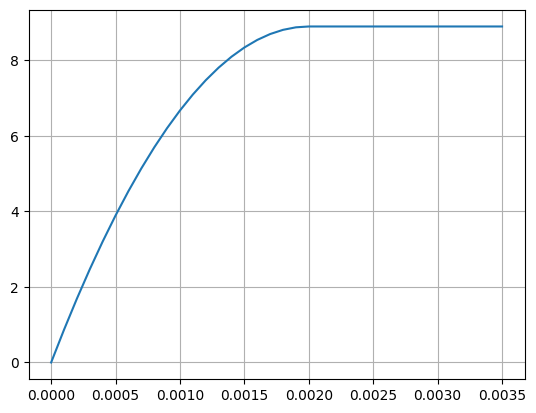

In [5]:
M20 = Concrete(20)
x = np.concatenate((np.linspace(0, 0.002, 21), np.linspace(0.0025, 0.0035, 6)))
y = np.array([M20.fc(ec) for ec in x])
plt.plot(x, y)
plt.grid()
plt.show()

## Define constants

We use an enumeration to represent the two types of rebars, and define a *class* for each type of rebar.

In [6]:
class RebarType(Enum):
    UNDEFINED = 0
    MS = 1
    HYSD = 2

ep: Array2D = np.array([[0, 0, 0.0001, 0.0003, 0.0007, 0.001, 0.002], [0, 0.8, 0.85, 0.9, 0.95, 0.975, 1]]).T

In [7]:
for rebar in RebarType:
    print(rebar)

RebarType.UNDEFINED
RebarType.MS
RebarType.HYSD


## Rebars
We implement an abstract base class that serves as a blueprint for the two subclasses that will represent the two types of rebars. This is called *inheritance* in OOP (Object Oriented Programming) terminology and is useful when you have multiple classes that inherit some properties from their parent class but implement other parts differently.

### Abstract base class for rebars

In [8]:
@dataclass
class Rebar(ABC):
    fy: float
    rebar_type: RebarType = RebarType.UNDEFINED
    label: str = ""
    Es: ClassVar[float] = 2e5

    @abstractmethod
    def fs(self, es: float) -> float:
        ...

    @property
    def fd(self) -> float:
        return 100 / 115 * self.fy

### Rebars with well defined yield point

In [9]:
@dataclass
class RebarMS(Rebar):
    def __post_init__(self):
        self.reabr_type: RebarType = RebarType.MS
        if not self.label:
            self.label = f"{self.rebar_type} {self.fy}"

        self.es_fs = np.array([[0.0, self.fd / self.Es], [0.0, self.fd]]).T
    
    def fs(self, es: float) -> float:
        _es = abs(es)
        fsy = self.es_fs[1, 1]
        if _es < fsy / self.Es:
            return es * self.Es
        else:
            return math.copysign(fsy, es)

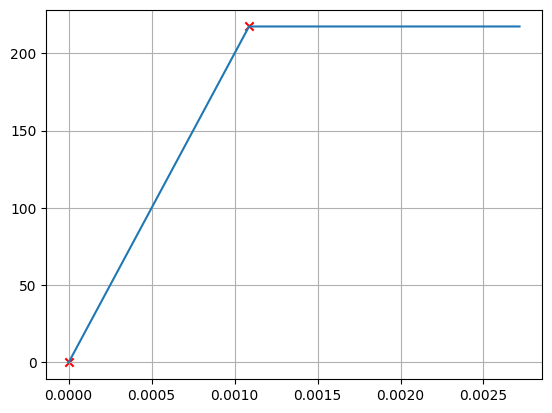

In [10]:
MS250 = RebarMS(250)
x = np.concatenate((np.linspace(MS250.es_fs[0, 0], MS250.es_fs[1, 0], 6), np.linspace(MS250.es_fs[1, 0], 2.5 * MS250.es_fs[1, 0], 6)))
y = np.array([MS250.fs(es) for es in x])

plt.plot(x, y)
plt.scatter(MS250.es_fs[:, 0], MS250.es_fs[:, 1], marker="x", color="red")
plt.grid()
plt.show()

### Coldworked deformed rebars

In [11]:
@dataclass
class RebarHYSD(Rebar):
    def __post_init__(self):
        self.rebar_type = RebarType.HYSD
        if not self.label:
            self.label = f"{self.rebar_type} {self.fy}"

        _ep: Array2D = np.array([[0.0, 0.0, 0.0001, 0.0003, 0.0007, 0.001, 0.002], [0.0, 0.8, 0.85, 0.9, 0.95, 0.975, 1.0]]).T
        self.es_fs = np.zeros(_ep.shape)
        self.es_fs = self.HYSD_es_fs(_ep)

    def HYSD_es_fs(self, ep: Array2D):
        es_fs = np.zeros(ep.shape)
        es_fs[:,1] = (self.fd * ep[:, 1])
        es_fs[:, 0] = es_fs[:, 1] / self.Es + ep[:, 0]
        return es_fs

    def fs(self, es: float) -> float:
        _es = abs(es)
        if _es <= self.es_fs[1, 0]:
            return es * self.Es
        elif _es >= self.es_fs[-1, 0]:
            return math.copysign(self.es_fs[-1, 1], es)
        else:
            # _es lies between FSD * 0.8 fy and FSD * fy
            i = 2
            numrows = self.es_fs.shape[0]
            while (_es > self.es_fs[i, 0]) and (i < numrows):
                i += 1
            if i > numrows:
                raise ValueError(f"Invalid strain value {es}")
            # print(i, es_fs[i, :])
            if math.isclose(_es, self.es_fs[i, 0]):
                return math.copysign(self.es_fs[i, 1], es)
            else:
                x1 = self.es_fs[i-1, 0]; y1 = self.es_fs[i-1, 1]
                x2 = self.es_fs[i, 0]; y2 = self.es_fs[i, 1]
                fs = y1 + (y2 - y1) / (x2 - x1) * (_es - x1)
                return math.copysign(fs, es)

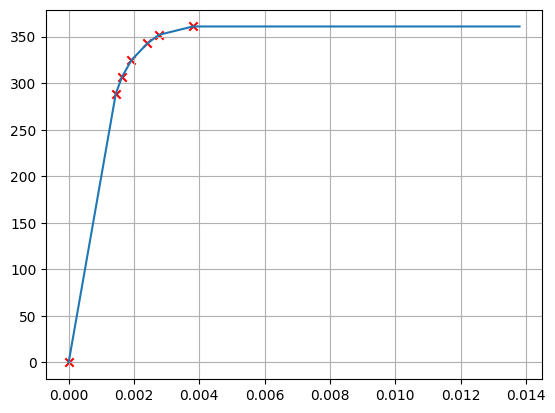

In [12]:
Fe415 = RebarHYSD(415, label="Fe 415")
Fe500 = RebarHYSD(500, label="Fe 500")

x = np.concatenate((
    Fe415.es_fs[0:2, 0],
    np.linspace(Fe415.es_fs[2, 0], Fe415.es_fs[3, 0], 11),
    np.linspace(Fe415.es_fs[3, 0], Fe415.es_fs[4, 0],11),
    np.linspace(Fe415.es_fs[4, 0], Fe415.es_fs[5, 0],11),
    np.linspace(Fe415.es_fs[5, 0], Fe415.es_fs[6, 0],11),
    np.array([Fe415.es_fs[6, 0], Fe415.es_fs[6, 0] + 0.01])
))
y = np.array([Fe415.fs(es) for es in x])

plt.plot(x, y)
plt.scatter(Fe415.es_fs[:, 0], Fe415.es_fs[:, 1], marker='x',color='red')
plt.grid()
plt.show()

## Concrete stress block parameters

When analysing or designing cross sections such as flanged section and rectangular columns subjected to axial compression and bending, it will be necessary to calculate area and centroid of only a portion of the compressive stress distribution in concrete. The following class accomplishes this task.

The following equations are based on the depth of the neutral axis $x_u$ measured from the compression edge and normalized distances to the fibres in compression $z_1 = \frac{x_1}{D}$ and $z_2 = \frac{x_2}{D}$ measured from the neutral axis towards the compression edge. The value of the stress is assumed to be unity. This merely calculates the area, moment and centroid of the stress distribution in concrete. In order to obtain the compressive force in concrete, we must multiply the area of the stress block with $\frac{0.67 f_{ck}}{\gamma_{mc}} \cdot b \cdot D$, where $b$ is the width of the rectangular section and $D$ is the overall depth of the section. Similarly, the multiplying factor for moment is $\frac{0.67 f_{ck}}{\gamma_{mc}} \cdot b \cdot D^2$. The distance of the centroid calculated by the function is from the compression edge, and is normalized with respect to $D$, that is $\bar{x} = \left(k - \bar{z} \right) D$ where $\bar{z} = \frac{\text{moment}}{\text{area}}$ is the distance of the centroid from the neutral axis.Obtaning the equations for the area and moment of the stress block requier that we express strain in terms of distance of the fibre from the neutral axis. Since the strain distribution is assumed to be linear, this is a straight forward process. 
We will use distance normalized in terms of the overall depth $D$ of the section.

\begin{align}
    x &= zD \qquad \therefore dx = D \, dz \\
    x_u &= kD \qquad 0 \leq k \leq 1 \text{ when neutral axis lies within the section, such as in the case of bending} \\
    \frac{\epsilon_c}{zD} &= \frac{\epsilon_{cy}}{\frac{4}{7} kD} \qquad \therefore \frac{\epsilon_c}{\epsilon_{cy}} = \frac{z}{\frac{4}{7} k} = \frac{z}{\alpha_k} \text{ where } \alpha_k = \frac{4}{7} k
\end{align}

Therefore the stress in concrete can be expressed as 
\begin{align}
    f_c &= \begin{cases}
    \frac{0.67 f_{ck}}{\gamma_{mc}} \left[ 2 \left( \frac{z}{\alpha_k} \right) - \left( \frac{z}{\alpha_k} \right)^2 \right] & \text{if } 0 \leq \epsilon_c \leq \epsilon_{cy} \\
    \frac{0.67 f_{ck}}{\gamma_{mc}} & \text{if } \epsilon_{cy} < \epsilon_c \leq \epsilon_{cu} \\
    0 & \text{if } \epsilon_c < 0 \text{ or } \epsilon_c > \epsilon_{cu}
    \end{cases}
\end{align}

Area and first moment of area are obtained by integrating $f_c$
\begin{align}
    A &= \int_{x_1}^{x_2} f_c dx & 0 \leq x_1 \leq x_2 \leq x_u \\
    M &= \int_{x_1}^{x_2} f_c x \, dx & 0 \leq x_1 \leq x_2 \leq x_u
\end{align}

For the parabolic portion of the stress distribution, this can be expressed in terms of the normalized distance $z$ as
\begin{align}
    A &= \frac{0.67 f_{ck}}{\gamma_{mc}} D \int_{z_1}^{z_2} 2 \left( \frac{z}{\alpha_k} \right) - \left( \frac{z}{\alpha_k} \right)^2 & 0 \leq z_1 \leq z_2 \leq \alpha_k \\
    &= \frac{0.67 f_{ck}}{\gamma_{mc}} D \left[ \frac{z^2}{\alpha_k} - \frac{z^3}{3 \alpha_k} \right]_{z_1}^{z_2} \\
    &= \frac{0.67 f_{ck}}{\gamma_{mc}} D \left[ \frac{z_2^2 - z_1^2}{\alpha_k} - \frac{z_2^3 - z_1^3}{3 \alpha_k} \right] \\
    M &= \frac{0.67 f_{ck}}{\gamma_{mc}} D^2 \int_{z_1}^{z_2} \left[ 2 \left( \frac{z}{\alpha_k} \right) - \left( \frac{z}{\alpha_k} \right)^2 \right] z \, dz & 0 \leq z_1 \leq z_2 \leq \alpha_k \\
    &= \frac{0.67 f_{ck}}{\gamma_{mc}} D^2 \left[ \left( \frac{2 z^3}{3 \alpha_k} \right) - \left( \frac{z^4}{4 \alpha_k^2} \right)^2 \right] & 0 \leq z_1 \leq z_2 \leq \alpha_k \\
    &= \frac{0.67 f_{ck}}{\gamma_{mc}} D^2 \left\{ \left[ \frac{2 \left( z_2^3 - z_1^3 \right)}{3 \alpha_k} \right] - \left[ \frac{\left( z_2^4 - z_1^4 \right)}{4 \alpha_k^2} \right] \right\} & 0 \leq z_1 \leq z_2 \leq \alpha_k
\end{align}

Similarly, for the constant portion of the stress distribution
\begin{align}
    A &= \frac{0.67 f_{ck}}{\gamma_{mc}} D \int_{z_1}^{z_2} dz & \alpha_k < z_1 \leq z_2 \leq k \\
    &= \frac{0.67 f_{ck}}{\gamma_{mc}} D \left[ z \right]_{z_1}^{z_2} \\
    &= \frac{0.67 f_{ck}}{\gamma_{mc}} D \left( z_2 - z_1 \right) \\
    M &= \frac{0.67 f_{ck}}{\gamma_{mc}} D^2 \int_{z_1}^{z_2} z \, dz & \alpha_k < z_1 \leq z_2 \leq k \\
    &= \frac{0.67 f_{ck}}{\gamma_{mc}} D^2 \left[ \frac{z^2}{2} \right]_{z_1}^{z_2} \\
    &= \frac{0.67 f_{ck}}{\gamma_{mc}} D^2 \left[ \frac{z_2^2 - z_1^2}{2} \right]
\end{align}

In case $z_1$ lies in the parabolic portion and $z_2$ lies in the constant portion, then the area and first moment of area must be computed as the sum of the two portions from $z = z_1$ to $z = \alpha_k$ for the parabolic portion and from $z=\alpha_k$ to $z_2$ for the constant portion.

The centroid of the stress distribution from the neutral axis is obtained as
\begin{align}
    \bar{z} &= \frac{M}{A}
\end{align}

The distance of the centroid from the compression edge is obtained as
\begin{align}
    \bar{x} &= kD - \bar{z} D = \left( k - \bar{z} \right) D
\end{align}

It can be shown that the same calculations apply for the case when the neutral axis lies outside the section as in the case of a section subjected to axial compression and uniaxial bending with the following changes:
\begin{align}
    \alpha_k &= k - \frac{3}{7} & 1 < k < \infty \qquad k - 1 \leq z_1 \leq z_2 \leq k
\end{align}
with the parabolic portion from $z=k-1$ to $z=\alpha_k$ and the constant portion from $z=\alpha_k$ to $z=k$.

In [13]:
class StressBlock(ABC):
    @abstractmethod
    def area(self, z1: float, z2: float) -> float:
        ...

    @abstractmethod
    def moment(self, z1: float, z2: float) -> float:
        ...

    @abstractmethod
    def centroid(self, z1: float, z2: float) -> float:
        ...
        
@dataclass
class CSB(StressBlock):
    k: float

    def __post_init__(self):
        if k < 0:
            raise ValueError(f"k = {self.k} must not be negative")
        if k <= 1:
            self.alpha_k = F(4, 7) * self.k
        else:
            self.alpha_k = self.k - F(3, 7)

    def z_values(self, z1: float, z2: float) -> tuple[tuple[float|None, float|None], tuple[float|None, float|None]]:
        if z1 > z2:  # Interchange z1 and z2 if z1 > z2
            z1, z2 = z2, z1

        if self.k >= 0:  # NA not negative
            if z2 <= self.alpha_k:  # Parabolic only
                return (z1, z2), (None, None)
            elif z1 >= self.alpha_k:  # Constant only
                return (None, None), (z1, z2)
            else:  # Partly parabolic and partly constant
                return (z1, self.alpha_k), (self.alpha_k, z2)
        else:  # self.k cannot be less than zero
            raise ValueError(f"k = {self.k} must not be less than zero")

    def area(self, _z1: float, _z2: float) -> float:
        """z1 znd z1 are measured from the NA towards the highly compressed edge. 0 <= z1 <= z2 <= infinity"""
        zp, zc = self.z_values(_z1, _z2)
        z1, z2 = zp
        z3, z4 = zc
        # print(f"{z1=} {z2=} {z3=} {z4=}")
        if z1 is None and z2 is None:  # Parabolic
            Ap = 0.0
        else:
            Ap = (z2**2 - z1**2) / self.alpha_k - (z2**3 - z1**3) / (3 * self.alpha_k**2)
        if z3 is None and z4 is None:  # Constant
            Ac = 0.0
        else:
            Ac = z4 - z3
        # print(f"{Ap=}, {Ac=}")
        return Ap + Ac

    def moment(self, _z1: float, _z2: float) -> float:
        """z1 znd z1 are measured from the NA towards the highly compressed edge. 0 <= z1 <= z2 <= infinity"""
        zp, zc = self.z_values(_z1, _z2)
        z1, z2 = zp
        z3, z4 = zc
        # print(f"{z1=} {z2=} {z3=} {z4=}")
        if z1 is None and z2 is None:  # Parabolic
            Mp = 0.0
        else:
            Mp = 2 * (z2**3 - z1**3) / (3 * self.alpha_k) - (z2**4 - z1**4) / (4 * self.alpha_k**2)
        if z3 is None and z4 is None:  # Constant
            Mc = 0.0
        else:
            Mc = (z4**2 - z3**2) / 2
        # print(f"{Mp=} {Mc=}")
        return Mp + Mc

    def centroid(self, z1: float, z2: float) -> float:
        """z1 znd z1 are measured from the NA towards the highly compressed edge. 0 <= z1 <= z2 <= infinity"""
        return self.k - self.moment(z1, z2) / self.area(z1, z2)

In [14]:
k = 0.3
z1 = 0
z2 = F(4, 7) * k / 2
# z2 = k
csb = CSB(k)

print(csb.k, csb.alpha_k)
print(csb.z_values(z1, z2))
print(f"A = {csb.area(z1, z2)}")
print(f"M = {csb.moment(z1, z2)}")
print(f"x_bar = {csb.centroid(z1, z2)}")

0.3 0.1714285714285714
((0, 0.0857142857142857), (None, None))
A = 0.03571428571428571
M = 0.001989795918367346
x_bar = 0.2442857142857143


## Design of rectangular sections for bending

Maxumum depth of neutral axis for a balanced section is $\frac{x_{u,max}}{d} = \frac{\epsilon_{cu}}{\epsilon_{cy} + \epsilon_{cu} + \frac{0.87 f_y}{E_s}}$. These equations are independent of the shape of the cross section.

Area of compressive stress distribution in concrete $A_c$ and the first moment of the compressive stress distribution about the neutral axis $M_c$ help us to compute the distance of the centroid of the compressive stress distribution from the compression edge $\bar{x}$. The computations have been carried out in rational numbers in order to avoid rounding of real number calculations.

From the area and centroid of the compressive stress distribution, we can obtain the limiting moment of a rectangular singly reinforced balanced section.

### Design of rectangular section for flexure

The depth of neutral axis $x_u$ required to generate the limiting moment of resistance $M_u \leq M_{u,lim}$ of a rectangular section is obtained by solving a quadratic equation and hence the corresponding required area of tension steel $A_{st}$.

In [15]:
@dataclass
class RectSection:
    b: float
    D: float
    clear_cover: float
    conc: Concrete
    tbars: Rebar
    cbars: Rebar
    vbars: Rebar
    tbar_dia: float = 20
    cbar_dia: float = 20
    vbar_dia: float = 8

    @property
    def d(self) -> float:
        return self.D - self.dc  # assuming a single layer of tension bars

    @property
    def dc(self) -> float:
        return self.clear_cover + self.cbar_dia / 2  # assuming a single layer of tension bars

    @property
    def Mulim(self):
        # xumax = self.xumax_d() * self.d
        return self.Mu(self.xumax)

    def ptlim_fy_fck(self) -> float:
        return F(115, 1) * self.Ac() * self.xumax_d()

    def xumax_d(self) -> float:
        return self.conc.ecu / (self.conc.ecy + self.conc.ecu + self.tbars.fd / self.tbars.Es)

    @property
    def xumax(self) -> float:
        return self.xumax_d() * self.d

    def Ac(self) -> F:
        A1 = F(2, 3) * F(4, 7)
        A2 = F(3, 7)
        return F(4, 9) * (A1 + A2)
    
    def Mc(self) -> F:
        A1 = F(2, 3) * F(4, 7)
        x1 = F(5, 8) * F(4, 7)
        A2 = F(3, 7)
        x2 = F(4, 7) + F(1, 2) * F(3, 7)
        Mc = A1 * x1 + A2 * x2
        return F(4, 9) * Mc
    
    def xbar(self) -> float:
        A = self.Ac()
        M = self.Mc()
        xx = M / A
        return F(1, 1) - xx

    def Mu(self, xu: float) -> float:
        xumax = self.xumax
        if xu > xumax:
            return ValueError(f"xu = {xu} cannot exceed {xumax}")
        if xu > self.D:
            return ValueError(f"xu = {xu} must lie within the section for bending")
        k = xu / self.D
        csb = CSB(k)
        A = csb.area(0, k) * self.conc.fd * self.D
        # M = csb.moment(0, k)
        xbar = csb.centroid(0, k) * self.D
        Mu = A * self.b * (self.d - xbar)
        # print(f"{k=}, {csb.area(0, k)} {A=}, {xbar=}, {Mu=}")
        return Mu

    def reqd_xu_d(self, Mu: float) -> float:
        """Required x_u can be calculated explicitly for an under-reinforced rectangular section"""
        return F(238, 198) - math.sqrt(F(238, 198)**2 - F(147, 22) * Mu / (self.conc.fck * self.b * self.d**2))

    def reqd_Ast(self, Mu: float) -> float:
        xu = self.reqd_xu_d(Mu) * self.d
        Ast = Mu / (self.tbars.fd * (self.d - self.xbar() * xu))
        return Ast

    def get_Asc(self, Mu: float) -> tuple[float, float]:
        # Mulim = get_Mulim_fck_bd2(self.tbars.fy) * self.conc.fck * self.b * self.d**2
        if Mu > self.Mulim:  # Doubly reinforced section
            xumax = self.xumax
            Ast1 = self.ptlim_fy_fck() * self.conc.fck / self.tbars.fy * self.b * self.d / 100
            esc = self.conc.ecu / xumax * (xumax - self.dc)
            fcc = self.conc.fc(esc)
            fsc = self.cbars.fs(esc)
            Mu2 = Mu - self.Mulim
            Asc = Mu2 / ((fsc - fcc) * (self.d - self.dc))
            Ast2 = Asc * (fsc - fcc) / (self.tbars.fd)
            return Asc, Ast1 + Ast2
        else:  # Singly reinforced section
            return 0.0, 0,0

    def Asc_Ast(self, Mu: float, factor: float = 1.0) -> tuple[float, float]:
        if Mu <= factor * self.Mulim:  # Singly reinforced section
            Asc = 0.0
            Ast = self.reqd_Ast(Mu)
        else:  # Doubly reinforced section
            Asc, Ast = self.get_Asc(Mu)
        return Asc, Ast

    def __str__(self) -> str:
        return f"Rectangular Section: {self.b}x{self.D} Concrete: {self.conc.label} Tension bars: {self.tbars.label}"

In [16]:
sec1 = RectSection(230, 450, 25, M20, Fe415, Fe415, Fe415)
print(sec1)
print(f"Mu_lim = {sec1.Mulim / 1e6:.2f} kNm")
print(f"A_st = {sec1.Asc_Ast(105e6)} mm^2")
print(f"A_st = {sec1.Asc_Ast(140e6)} mm^2")
print(f"A_st = {sec1.Asc_Ast(90e6)} mm^2")

Rectangular Section: 230x450 Concrete: M20 Tension bars: Fe 415
Mu_lim = 109.36 kNm
A_st = (0.0, 864.4277555791792) mm^2
A_st = (234.3896368195523, 1135.4443269638653) mm^2
A_st = (0.0, 711.6397607911738) mm^2


In [17]:
print(f"Ac = {sec1.Ac()}, Mc = {sec1.Mc()}, x_bar = {sec1.xbar()}")
csb = CSB(1.0)
print(f"{csb.area(0, 1) * F(4, 9)}, {csb.moment(0, 1) * F(4, 9)}, x_bar = {csb.centroid(0, 1)}")
xumax = sec1.xumax
print(sec1.Mu(xumax)/1e6)
print(sec1.Mu(xumax * 0.8)/1e6)
try:
    Mu = sec1.Mu(xumax * 1.2)
    print(Mu)
except Exception as e:
    print(e)

Ac = 68/189, Mc = 278/1323, x_bar = 99/238
0.35978835978835977, 0.21012849584278157, x_bar = 0.4159663865546218
109.35741025171643
91.84157395439662
xu = 238.625 cannot exceed 198.85416666666669


In [18]:
sec2 = RectSection(230, 450, 25, M20, Fe415, Fe415, Fe415)
print(f"xu_max = {sec2.xumax_d() * sec2.d:.2f} Mu_lim = {sec2.Mulim/1e6:.2f}")
for xu in [50, 100, 175, 195]:
    print(f"xu = {xu} mm, Mu = {sec2.Mu(xu) / 1e6:.2f}")

xu_max = 198.85 Mu_lim = 109.36
xu = 50 mm, Mu = 32.62
xu = 100 mm, Mu = 61.80
xu = 175 mm, Mu = 99.11
xu = 195 mm, Mu = 107.76


## Design of flanged sections

Flanged sections are treated as a superposition of a rectangular section and the remaining rectangular portion of the flange. The limiting moment of resistance $M_{u,lim}$ of the section can be computed considering two distinct cases:

1. The limiting depth of the neutral axis $x_{u,max}$ lies below the flange. This occurs when the depth of the flange $d_f > \frac{\epsilon_{cu}}{\epsilon_{cy} + \epsilon_{cu} + \frac{0.87 f_y}{E_s}}$
2. The limiting depth of the neutral axis lies within the flange.

In case $x_{u,max} \leq d_f$, the section must be designed as a rectangular section of size $b_f \times d$ subject to the condition that the width available to place the tension rebars is $b_w$. However, in case $x_{u,max} > d_f$, we must know the moment of resistance of the section $M_{u1}$ for the case when $x_u = d_f$ and $M_{u2}$ when $x_u = x_{u,max}$. If $M_u \leq M_{u1}$, the neutral axis must lie within the flange and the section must be designed as a rectangular section of size $b_f \times d$ similar to the case above. If $M_u > M_{u2}$, the design must be caried out by iteratively changing the value of $x_u$ until the required moment of resistance is attained.

In [19]:
@dataclass
class FlangedSection(RectSection):
    bf: float = 0.0
    df: float = 0.0

    @property
    def bw(self) -> float:
        return self.b

    @property
    def Mulim(self):
        """Limiting moment of resistance of flanged sections"""
        xumax = self.xumax
        return self.Mu(xumax)

    def Mu(self, xu: float) -> float:
        xumax = self.xumax
        # print(f"{xumax=}", end=" ")
        if xu > xumax:
            raise ValueError(f"xu ({xu}) > xumax={xumax}")

        if 0 <= xu <= self.D:  # NA lies within the section for bending
            k = xu / self.D
            # print(f"*** {xu=} {self.df=} {k=} {xu * float(F(3, 7))}")
            csb = CSB(k)
            if xu <= self.df:  # NA within the flange
                z1 = 0
                z2 = k
                A = csb.area(z1, z2)
                x_bar = csb.centroid(z1, z2) * self.D
                Mu = self.conc.fd * self.D * A * self.bf * (self.d - x_bar)
                # print(f"{z1=} {z2=} {A=} {Mu=}")
            else:  # NA outside the flange
                Mw = super().Mu(xu)
                if self.df <= xu * F(3, 7):  # Flange very thin flange and stress in flange is constant
                    z1 = (xu - self.df) / self.D
                    z2 = k
                    Af = self.conc.fd * self.D * csb.area(z1, z2) * (self.bf - self.bw)
                    x_bar = csb.centroid(z1, z2) * self.D
                    Mf = Af * (self.d - x_bar)
                    Mu = Mw + Mf
                    # print(f"Thin flange: CSB Area = {csb.area(z1, z2)} centroid = {x_bar} {Af=} {Mw=} {Mf=} {Mu=}")
                    # print(f"Thick flange: {Mw=} {Mf=} {Mu=}")
                else:                        # Flange thick, stress in flange is parabolic + constant
                    z1 = (xu - self.df) / self.D
                    z2 = k
                    Af = self.conc.fd * self.D * csb.area(z1, z2) * (self.bf - self.bw)
                    x_bar = csb.centroid(z1, z2) * self.D
                    Mf = Af * (self.d - x_bar)
                    Mu = Mw + Mf
                    # print(f"Thick flange: {Mw=} {Mf=} {Mu=}")
            return Mu
        else:
            raise ValueError(f"Distance of NA x_u = {xu} > {self.D}")
        

    def reqd_xu(self, Mu: float) -> float:
        def find_xu(xu: float, reqd_Mu: float) -> float:
            return reqd_Mu - self.Mu(xu)

        xumax = self.xumax
        Mulim = self.Mulim
        # print(f"{xumax=} {Mulim=}")
        if xumax <= self.df:  # NA lies within the flange
            reqd_xu = F(238, 198) - math.sqrt(F(238, 198)**2 - F(147, 22) * Mu / (self.conc.fck * self.bf * self.d**2))
            # print(f"1: Rectangular section {self.bf} x {self.d} {reqd_xu * self.d}")
            return reqd_xu * self.d
        else:
            Mu1 = self.Mu(self.df)
            if Mu <= Mu1:  # Required NA lies within the flange
                reqd_xu = F(238, 198) - math.sqrt(F(238, 198)**2 - F(147, 22) * Mu / (self.conc.fck * self.bf * self.d**2))
                # print(f"2: Rectangular section {self.bf} x {self.d} {reqd_xu * self.d}")
                return reqd_xu * self.d
            else:  # Required NA lies below flange
                Mulim = self.Mulim
                if Mu <= Mulim:  # Singly reinforced flanged section
                    # print(f"3: NA below flange Singly reinforced: {Mu=} {Mulim=}")
                    bracket = find_bracket(find_xu, tsec.df, tsec.xumax, 10, reqd_Mu=Mu)
                    reqd_xu = brent_root(find_xu, bracket[0], bracket[1], reqd_Mu=Mu)
                    return reqd_xu
                else:  # Doubly reinforced flanged section
                    print(f"4: NA below flange Doubly reinforced: {Mu=} {Mulim=}")

    def __str__(self) -> str:
        s = f"Flanged Section: {self.bw}x{self.D} "
        if self.bf and self.df:
           s += f"bf={self.bf} df={self.df}"
        return s

In [20]:
tsec = FlangedSection(230.0, 450.0, 25.0, M20, Fe500, Fe500, Fe415, bf=900, df=150.0)
for Mu in [290.0, 340.0, 343.0, 370.0, 380.0, tsec.Mulim / 1e6 + 1]:
    xu = tsec.reqd_xu(Mu*1e6)
    if xu:
        print(f"xu={xu:.2f}, Mu={tsec.Mu(xu)/1e6:.2f} kNm")

xu=123.09, Mu=290.00 kNm
xu=148.66, Mu=340.00 kNm
xu=150.00, Mu=342.53 kNm
xu=165.71, Mu=367.59 kNm
xu=175.82, Mu=380.00 kNm
4: NA below flange Doubly reinforced: Mu=394420272.52750033 Mulim=393420272.52750033


In [21]:
tsec = FlangedSection(230.0, 450.0, 25.0, M20, Fe500, Fe500, Fe415, bf=900, df=150.0)
for xu in [125.0, 150.0, 175.0]:
    print(f"{xu=} Mu={tsec.Mu(xu)/1e6:.2f} N mm")

xu=125.0 Mu=293.86 N mm
xu=150.0 Mu=342.53 N mm
xu=175.0 Mu=379.08 N mm


In [22]:
for Mu in [290.0, 340.0]:
    xu = tsec.reqd_xu(Mu * 1e6)
    print(f"Required xu = {xu} {tsec.Mu(xu)/1e6}")

Required xu = 123.0881768670827 289.99999999999994
Required xu = 148.65612846502893 340.0


In [23]:
tsec = FlangedSection(230.0, 450.0, 25.0, M20, Fe500, Fe500, Fe415, bf=900, df=75.0)
print(tsec)
for xu in [125.0, 150.0, 175.0]:
    print(f"{xu=} Mu={tsec.Mu(xu)/1e6:.2f} N mm")

Flanged Section: 230.0x450.0 bf=900 df=75.0
xu=125.0 Mu=242.39 N mm
xu=150.0 Mu=256.04 N mm
xu=175.0 Mu=267.73 N mm
